# Studies focused on the pressure sensitivity of SLIDE model

In [1]:
%matplotlib widget
import time
from bmcs_expsim.utils.mlab_decorators import decorate_figure
from mayavi import mlab
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.pylab as plt
import numpy as np
from ibvpy.api import TStepBC , TFCyclicNonsymmetricConstant, TFBilinear
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_interface import XDomainFEInterface
from ibvpy.fets import FETS2D4Q
from ibvpy.fets.fets1D5 import FETS1D52ULRH
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from bmcs_matmod.slide.vslide_34_TN_axisym import Slide34
from ibvpy.tmodel.mats3D.mats3D_elastic.vmats3D_elastic import \
    MATS3DElastic
from ibvpy.tmodel.mats2D.mats2D_elastic.vmats2D_elastic import \
    MATS2DElastic
from bmcs_matmod.slide.slide_explorer import SlideExplorer

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


## Geometry, BC and Material Parameters

In [2]:
n_y_e = 1
n_inner_x_e = 1
n_outer_x_e = 1
L_x = 1
R_in = 1
R_out = 2
P = 1.

xd_lower = XDomainFEGrid(integ_factor = P,
                         coord_min=(0, 0),
                          coord_max=(L_x, R_in),
                          shape=(n_y_e, n_inner_x_e),
                          fets=FETS2D4Q())
xd_upper = XDomainFEGrid(integ_factor = P,
                         coord_min=(0, R_in),
                          coord_max=(L_x, R_out),
                          shape=(n_y_e, n_outer_x_e),
                          fets=FETS2D4Q())
m1 = MATS2DElastic(E=37000, nu=0.18)
m2 = MATS2DElastic(E=37000, nu=0.18)

xd12 = XDomainFEInterface(
    integ_factor = P,
    I=xd_lower.mesh.I[:, -1],
    J=xd_upper.mesh.I[:, 0],
    fets=FETS1D52ULRH()
)

# Study 1: large threshold function

In [3]:
material_params =  dict(
     E_T=400, gamma_T=500, K_T=50, S_T=0.3, c_T=3, bartau=15,
     E_N=300, S_N=0.05, c_N = 3, m = 1.0, f_t=2, f_c=100, f_c0 = 80, eta=0.1)



bond_m = Slide34(**material_params)

### Monotonic case

In [4]:
m_thres_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )


lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

tf_first = TFBilinear(loading_ratio=1.0, time_ratio=0.05)
tf_second = TFBilinear(loading_ratio=0.00, time_ratio=0.05)

compression_list = np.linspace(-10,-35,2)

In [5]:
m_list_thres_mon = []

for c in compression_list:
    m_thres_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_second)

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=-2/material_params['f_c'],  time_function=tf_first)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_first)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1,lower_slide] + upper_compression_force_first

    m_thres_mon.bc=bc1
    m_thres_mon.hist.vis_record = {
        'stress': Vis3DTensorField(var='sig_ab'),
    }

    s = m_thres_mon.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.01
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_thres_mon.append(m_thres_mon)

44.63741022380079
59.94752694827141


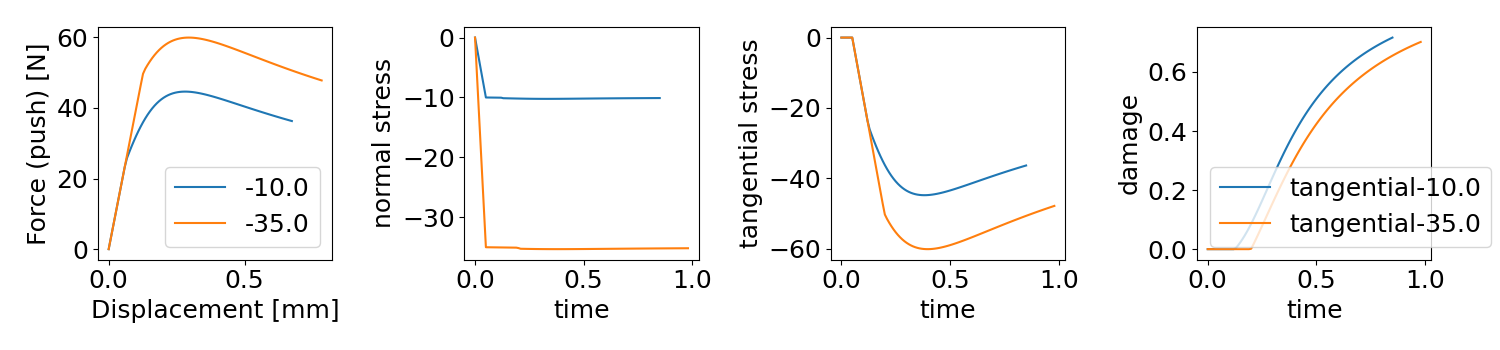

In [7]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

max_tau = []
for m,c in zip(m_list_thres_mon,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    print(max(F_inner_t))
    max_tau.append(max(F_inner_t))

    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()

plt.show()

plt.savefig('monotonic_large_elastic.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)


## Cyclic loading

In [8]:
m_thres_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

tf_precrompression = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 0, unloading_ratio = 1.0)
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 1, unloading_ratio = 0.2)


list_param = np.linspace(300,500,3)
compression_list = np.linspace(-10,-35,2)
#list_param = [500]
max_tau = [38.46641793836478, 49.592421717344706]
bond_m = Slide34(**material_params)

m_list_thres_cyc = []
S_max = 0.8

In [9]:
s.tline.step

0.01

In [10]:
for (c,p) in zip(compression_list,max_tau):
    m_thres_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_cyclic)

    push = p * S_max / len(lower_slide.dofs)
    push_force = [BCDof(var='f', dof=dof, value=push, time_function=tf_cyclic)
                                     for dof in lower_slide.dofs]

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=-2/material_params['f_c'],  time_function=tf_precrompression)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_precrompression)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1] + upper_compression_force_first + push_force

    m_thres_cyc.bc=bc1
    m_thres_cyc.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m_thres_cyc.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = (1/(100*5))
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_thres_cyc.append(m_thres_cyc)

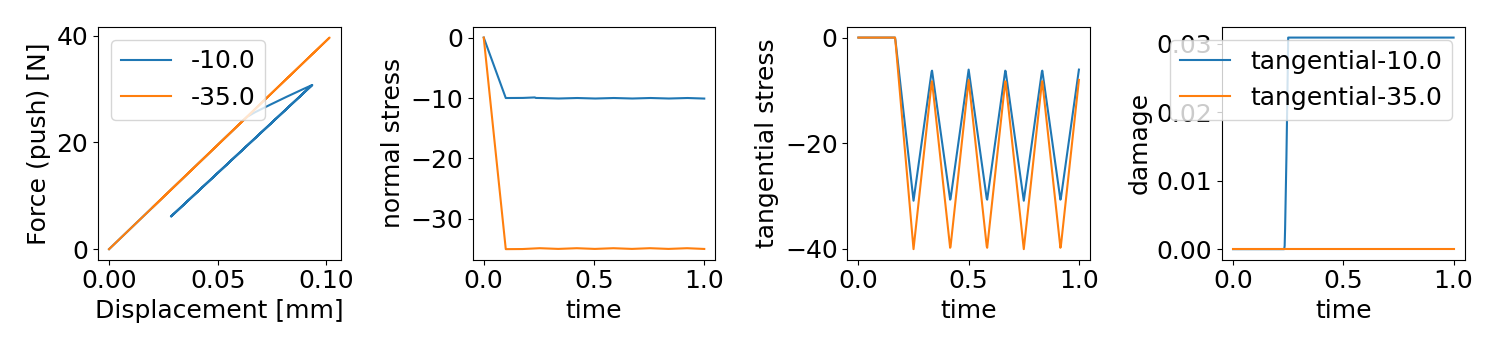

In [11]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

for m,c in zip(m_list_thres_cyc,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    
    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()
plt.rcParams.update({'font.size': 18})

plt.show()

plt.savefig('cyclic_large_elastic.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)

In [12]:
se_list=[]
for c in compression_list:
    se1 = SlideExplorer(n_steps=100, k_max=500)
    se1.slide_model.trait_set(**material_params)
    se1.trait_set(s_x_1 = 0, s_y_1 = 0, w_1 = c/material_params['E_N']);
    se1.run()
    se1.trait_set(s_x_1 = 1, s_y_1 = 0, w_1 = c/material_params['E_N']);
    se1.run()
    #se1.trait_set(s_x_1 = 0.22, s_y_1 = 0, w_1 = -material_params['f_c']*c/material_params['E_N']);
    #se1.run()
    #se1.trait_set(s_x_1 = 0.5, s_y_1 = 0, w_1 = -material_params['f_c']*c/material_params['E_N']);
    #se1.run()
    se_list.append(se1)

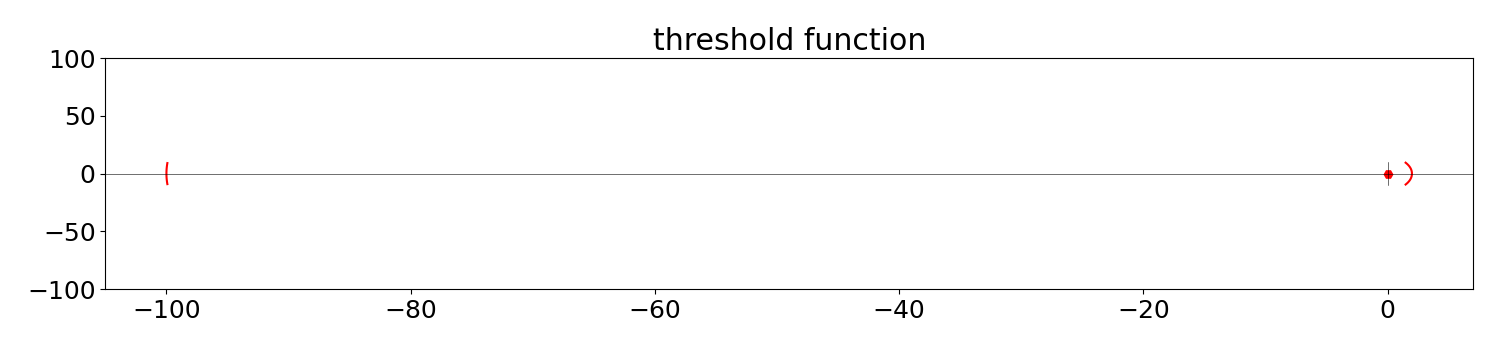

In [13]:
f, (ax1) = plt.subplots(1, 1, tight_layout=True, figsize=(15,3.5))

se1.slide_model.plot_f_state(ax1, se1.Eps_t[0], se1.Sig_t[0], color='red')
ax1.set_ylim(-100,100)
plt.savefig('threshold_large_elastic.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)

## Study 2: Damage off

In [14]:
material_params_dam_off =  dict(
     E_T=200, gamma_T=100, K_T=50, S_T=10000000.3, c_T=3, bartau=5,
     E_N=300, S_N=100000.05, c_N = 3, m = 0.2, f_t=2, f_c=100, f_c0 = 80, eta=0.0)



bond_m = Slide34(**material_params_dam_off)

### Monotonic case

In [15]:
m_dam_mon_off = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )


lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

tf_first = TFBilinear(loading_ratio=1.0, time_ratio=0.05)
tf_second = TFBilinear(loading_ratio=0.00, time_ratio=0.05)

compression_list = np.linspace(-10,-35,2)

In [16]:
m_list_dam_mon_off = []

for c in compression_list:
    m_dam_mon_off = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_second)

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_first)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_first)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1,lower_slide] + upper_compression_force_first

    m_dam_mon_off.bc=bc1
    m_dam_mon_off.hist.vis_record = {
        'stress': Vis3DTensorField(var='sig_ab'),
    }

    s = m_dam_mon_off.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.01
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_dam_mon_off.append(m_dam_mon_off)

72.34338946897955
75.19155945140315


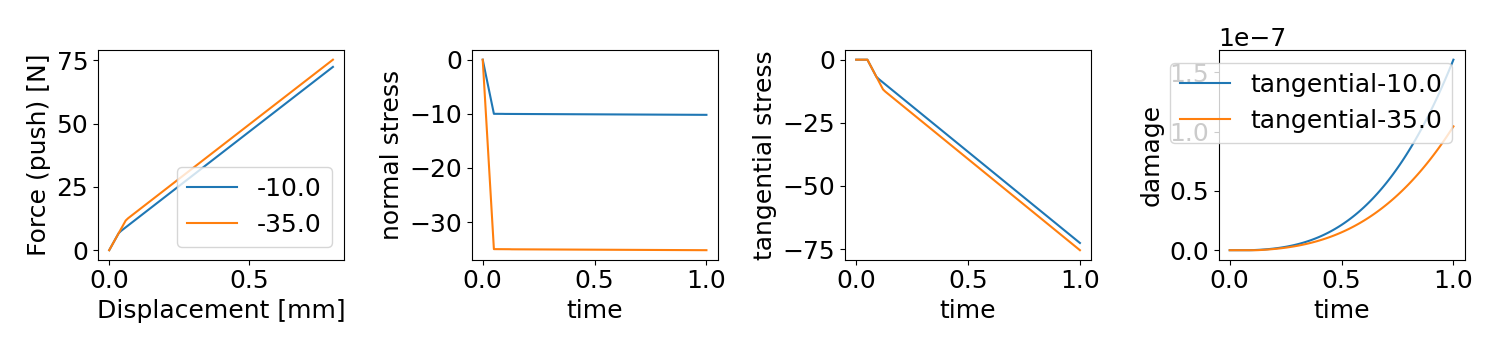

In [17]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

max_tau = []
for m,c in zip(m_list_dam_mon_off,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    print(max(F_inner_t))
    max_tau.append(max(F_inner_t))

    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()

plt.show()

plt.savefig('monotonic_dam_off.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)


# Cyclic loading

In [18]:
m_dam_off_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

tf_precrompression = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 0, unloading_ratio = 1.0)
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 1, unloading_ratio = 0.05)


list_param = np.linspace(300,500,3)
compression_list = np.linspace(-10,-35,2)
#list_param = [500]
max_tau = [70, 70]
bond_m = Slide34(**material_params_dam_off)

m_list_dam_off_cyc = []
S_max = 0.9

In [19]:
for (c,p) in zip(compression_list,max_tau):
    m_dam_off_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_cyclic)

    push = p * S_max / len(lower_slide.dofs)
    push_force = [BCDof(var='f', dof=dof, value=push, time_function=tf_cyclic)
                                     for dof in lower_slide.dofs]

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_precrompression)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_precrompression)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1] + upper_compression_force_first + push_force

    m_dam_off_cyc.bc=bc1
    m_dam_off_cyc.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m_dam_off_cyc.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = (1/(100*5))
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_dam_off_cyc.append(m_dam_off_cyc)

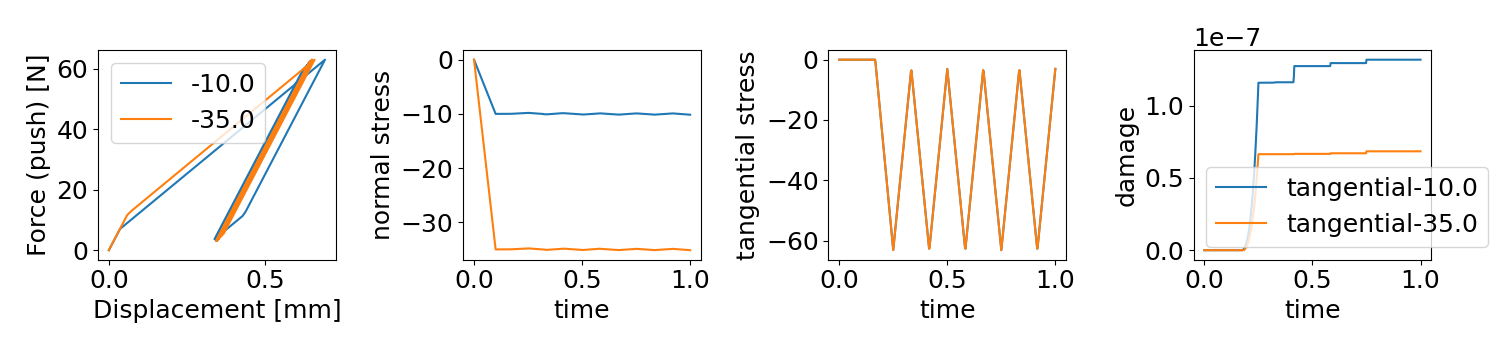

In [20]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

for m,c in zip(m_list_dam_off_cyc,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    
    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()
plt.rcParams.update({'font.size': 18})

plt.show()

plt.savefig('cyclic_dam_off.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)

In [21]:
se_list=[]
for c in compression_list:
    se1 = SlideExplorer(n_steps=100, k_max=500)
    se1.slide_model.trait_set(**material_params_dam_off)
    se1.trait_set(s_x_1 = 0, s_y_1 = 0, w_1 = c/material_params['E_N']);
    se1.run()
    se1.trait_set(s_x_1 = 1, s_y_1 = 0, w_1 = c/material_params['E_N']);
    se1.run()
    #se1.trait_set(s_x_1 = 0.22, s_y_1 = 0, w_1 = -material_params['f_c']*c/material_params['E_N']);
    #se1.run()
    #se1.trait_set(s_x_1 = 0.5, s_y_1 = 0, w_1 = -material_params['f_c']*c/material_params['E_N']);
    #se1.run()
    se_list.append(se1)

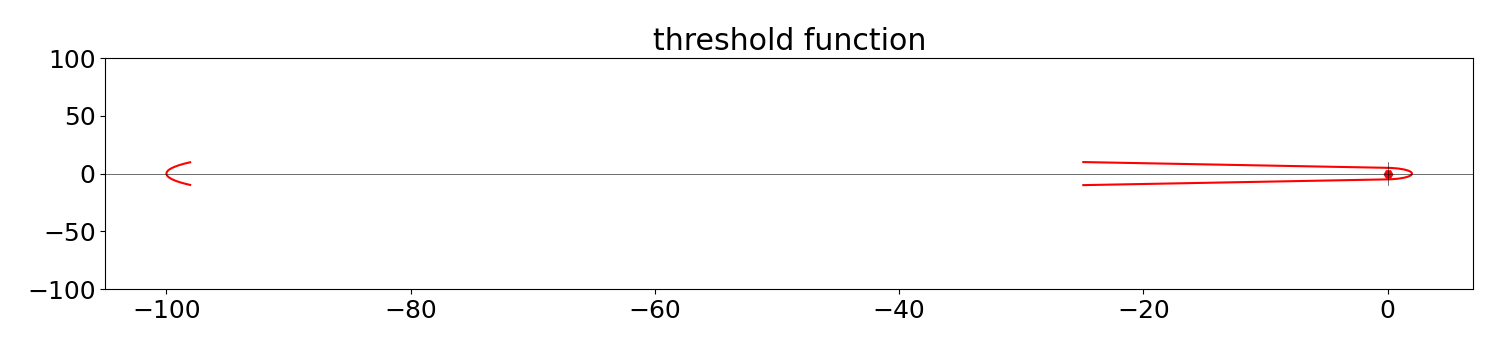

In [22]:
f, (ax1) = plt.subplots(1, 1, tight_layout=True, figsize=(15,3.5))

se1.slide_model.plot_f_state(ax1, se1.Eps_t[0], se1.Sig_t[0], color='red')
ax1.set_ylim(-100,100)
plt.savefig('threshold_damage_off.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)

# Study 3: introducing some damage

In [23]:
material_params_dam =  dict(
     E_T=200, gamma_T=400, K_T=0, S_T=1.5, c_T=4, bartau=5,
     E_N=300, S_N=1.5, c_N = 3, m = 0.2, f_t=2, f_c=100, f_c0 = 80, eta=0.0)



bond_m = Slide34(**material_params_dam)

In [24]:
se1 = SlideExplorer(n_steps=100, k_max=50)
se1.slide_model.trait_set(**material_params)
se1.trait_set(s_x_1 = 0.0, s_y_1 = 0, w_1 = -30);
se1.run()
se1.trait_set(s_x_1 = 0.4, s_y_1 = 0, w_1 = 0);
se1.run()

<lambdifygenerated-81>:4: RuntimeWarning: overflow encountered in double_scalars
  return select([less((abs(sqrt((-X_x + tau_pi_x/(1 - omega_T))**2 + (-X_y + tau_pi_y/(1 - omega_T))**2)) - (Z + bartau)*(sig_pi/(-omega_N*Dummy_634 + 1) + f_t**2*m/(Z + bartau - 2*f_t*m))*(Z + bartau - 2*f_t*m)/(f_t**2*m))*sign(f_t)*sign(m), 0),less((abs(sqrt((-X_x + tau_pi_x/(1 - omega_T))**2 + (-X_y + tau_pi_y/(1 - omega_T))**2)) + (Z + bartau + f_c0*m)*(sig_pi/(-omega_N*Dummy_634 + 1) + f_c0 - m*(-f_c**2 + 2*f_c*f_c0 - f_c0**2)/(Z + bartau + 2*f_c*m - f_c0*m))*(Z + bartau + 2*f_c*m - f_c0*m)/(m*(-f_c**2 + 2*f_c*f_c0 - f_c0**2)))*sign(m)*sign(-f_c + f_c0), 0),True], [sqrt(((-X_x + tau_pi_x/(1 - omega_T))**2 + (-X_y + tau_pi_y/(1 - omega_T))**2)*(f_t**2*m**2 - 2*f_t*m*(Z + bartau) + (Z + bartau)**2)**2/((Z + bartau)*(-Z - bartau + f_t*m)**2*(Z + bartau - 2*f_t*m)) + (sig_pi/(-omega_N*Dummy_634 + 1) + f_t**2*m/(Z + bartau - 2*f_t*m))**2*(f_t**2*m**2 - 2*f_t*m*(Z + bartau) + (Z + bartau)**2)**2/(f_t**2*(Z 

ConvergenceError: no convergence for step for state [0.008000001, 1e-09, -29.399999999]

### Monotonic case

In [ ]:
m_dam_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )


lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

tf_first = TFBilinear(loading_ratio=1.0, time_ratio=0.05)
tf_second = TFBilinear(loading_ratio=0.00, time_ratio=0.05)

compression_list = [-10] # np.linspace(-10,-35,2)

In [ ]:
m_list_dam_mon = []

for c in compression_list:
    m_dam_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_second)

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_first)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_first)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1,lower_slide] + upper_compression_force_first

    m_dam_mon.bc=bc1
    m_dam_mon.hist.vis_record = {
        'stress': Vis3DTensorField(var='sig_ab'),
    }

    s = m_dam_mon.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.01
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_dam_mon.append(m_dam_mon)

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

max_tau = []
for m,c in zip(m_list_dam_mon,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    print(max(F_inner_t))
    max_tau.append(max(F_inner_t))

    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()

plt.show()

plt.savefig('monotonic_damage.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

57.15001026821468


## Cyclic loading

In [ ]:
m_dam_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

tf_precrompression = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 0, unloading_ratio = 1.0)
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 1, unloading_ratio = 0.05)


list_param = np.linspace(300,500,3)
compression_list = np.linspace(-5,-50,2)
#list_param = [500]
#max_tau = [38.46641793836478, 49.592421717344706]
bond_m = Slide34(**material_params_dam)

m_list_dam_cyc = []
S_max = 0.65

In [ ]:
for (c,p) in zip(compression_list,max_tau):
    m_dam_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_cyclic)

    push = p * S_max / len(lower_slide.dofs)
    push_force = [BCDof(var='f', dof=dof, value=push, time_function=tf_cyclic)
                                     for dof in lower_slide.dofs]

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_precrompression)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_precrompression)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1] + upper_compression_force_first + push_force

    m_dam_cyc.bc=bc1
    m_dam_cyc.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m_dam_cyc.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = (1/(100*5))
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_dam_cyc.append(m_dam_cyc)

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

for m,c in zip(m_list_dam_cyc,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    
    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()
plt.rcParams.update({'font.size': 18})

plt.show()

plt.savefig('cyclic_damage.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Study 4: small tangential elastic limit

In [ ]:
material_params_tg =  dict(
     E_T=200, gamma_T=400, K_T=0, S_T=1.5, c_T=4, bartau=0.5,
     E_N=300, S_N=100000.05, c_N = 3, m = 0.4, f_t=0.2, f_c=100, f_c0 = 80, eta=0.0)



bond_m = Slide34(**material_params_tg)

### Monotonic case

In [ ]:
m_tg_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )


lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

tf_first = TFBilinear(loading_ratio=1.0, time_ratio=0.05)
tf_second = TFBilinear(loading_ratio=0.00, time_ratio=0.05)

compression_list = np.linspace(-10,-35,2)

In [ ]:
m_list_tg_mon = []

for c in compression_list:
    m_tg_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_second)

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_first)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_first)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1,lower_slide] + upper_compression_force_first

    m_tg_mon.bc=bc1
    m_tg_mon.hist.vis_record = {
        'stress': Vis3DTensorField(var='sig_ab'),
    }

    s = m_tg_mon.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.01
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_tg_mon.append(m_tg_mon)

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

max_tau = []
for m,c in zip(m_list_tg_mon,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    print(max(F_inner_t))
    max_tau.append(max(F_inner_t))

    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()

plt.show()

plt.savefig('monotonic_small_tg.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

52.70393457165165
52.80796105955274


## Cyclic loading

In [ ]:
m_tg_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

tf_precrompression = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 0, unloading_ratio = 1.0)
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 1, unloading_ratio = 0.05)


list_param = np.linspace(300,500,3)
compression_list = np.linspace(-10,-50,2)
#list_param = [500]
#max_tau = [38.46641793836478, 49.592421717344706]
bond_m = Slide34(**material_params_tg)

m_list_tg_cyc = []
S_max = 0.65

In [ ]:
compression_list

array([-10., -50.])

In [ ]:
for (c,p) in zip(compression_list,max_tau):
    _v_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_cyclic)

    push = p * S_max / len(lower_slide.dofs)
    push_force = [BCDof(var='f', dof=dof, value=push, time_function=tf_cyclic)
                                     for dof in lower_slide.dofs]

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_precrompression)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_precrompression)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1] + upper_compression_force_first + push_force

    m_tg_cyc.bc=bc1
    m_tg_cyc.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m_tg_cyc.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = (1/(100*5))
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_tg_cyc.append(m_tg_cyc)

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

for m,c in zip(m_list_tg_cyc,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    
    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()
plt.rcParams.update({'font.size': 18})

plt.show()

plt.savefig('cyclic_small_tg.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Study 5: very large hardening value

In [4]:
material_params_hard =  dict(
     E_T=200, gamma_T=10000, K_T=0, S_T=1.5, c_T=4, bartau=0.5,
     E_N=300, S_N=100000.05, c_N = 3, m = 0.4, f_t=0.2, f_c=100, f_c0 = 80, eta=0.0)



bond_m = Slide34(**material_params_hard)

### Monotonic case

In [5]:
m_hard_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )


lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

tf_first = TFBilinear(loading_ratio=1.0, time_ratio=0.05)
tf_second = TFBilinear(loading_ratio=0.00, time_ratio=0.05)

compression_list = np.linspace(-10,-35,2)

In [6]:
m_list_hard_mon = []

for c in compression_list:
    m_hard_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_second)

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_first)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_first)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1,lower_slide] + upper_compression_force_first

    m_hard_mon.bc=bc1
    m_hard_mon.hist.vis_record = {
        'stress': Vis3DTensorField(var='sig_ab'),
    }

    s = m_hard_mon.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.01
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_hard_mon.append(m_hard_mon)

In [22]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

max_tau = []
for m,c in zip(m_list_hard_mon,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    print(max(F_inner_t))
    max_tau.append(max(F_inner_t))

    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()

plt.show()

plt.savefig('monotonic_large_hard.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

132.02086519111043
132.13684509296755


## Cyclic loading

In [ ]:
m_hard_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

tf_precrompression = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 0, unloading_ratio = 1.0)
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 1, unloading_ratio = 0.2)


list_param = np.linspace(300,500,3)
compression_list = np.linspace(-10,-35,2)
#list_param = [500]
#max_tau = [38.46641793836478, 49.592421717344706]
bond_m = Slide34(**material_params_hard)

m_list_hard_cyc = []
S_max = 0.8

In [ ]:
for (c,p) in zip(compression_list,max_tau):
    _v_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_cyclic)

    push = p * S_max / len(lower_slide.dofs)
    push_force = [BCDof(var='f', dof=dof, value=push, time_function=tf_cyclic)
                                     for dof in lower_slide.dofs]

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_precrompression)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_precrompression)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1] + upper_compression_force_first + push_force

    m_hard_cyc.bc=bc1
    m_hard_cyc.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m_hard_cyc.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = (1/(100*5))
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_hard_cyc.append(m_hard_cyc)

In [21]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

for m,c in zip(m_list_hard_cyc,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    
    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()
plt.rcParams.update({'font.size': 18})

plt.show()

plt.savefig('cyclic_large_hard.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'm_list_hard_cyc' is not defined

# Study 6: brittle behavior

In [17]:
material_params_brit =  dict(
     E_T=200, gamma_T=400, K_T=0, S_T=0.05, c_T=4, bartau=0.5,
     E_N=300, S_N=100000.05, c_N = 3, m = 0.4, f_t=0.2, f_c=100, f_c0 = 80, eta=0.0)



bond_m = Slide34(**material_params_brit)

### Monotonic case

In [18]:
m_brit_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )


lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

tf_first = TFBilinear(loading_ratio=1.0, time_ratio=0.05)
tf_second = TFBilinear(loading_ratio=0.00, time_ratio=0.05)

compression_list = np.linspace(-10,-35,2)

In [19]:
m_list_brit_mon = []

for c in compression_list:
    m_brit_mon = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_second)

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=0,  time_function=tf_first)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_first)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1,lower_slide] + upper_compression_force_first

    m_brit_mon.bc=bc1
    m_brit_mon.hist.vis_record = {
        'stress': Vis3DTensorField(var='sig_ab'),
    }

    s = m_brit_mon.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.01
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_brit_mon.append(m_brit_mon)

In [20]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

max_tau = []
for m,c in zip(m_list_brit_mon,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    print(max(F_inner_t))
    max_tau.append(max(F_inner_t))

    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()

plt.show()

plt.savefig('monotonic_brittle.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

16.280364492979793
17.48104372980757


## Cyclic loading

In [ ]:
m_hard_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

tf_precrompression = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 0, unloading_ratio = 1.0)
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles = 5, shift_cycles = 1, unloading_ratio = 0.2)


list_param = np.linspace(300,500,3)
compression_list = np.linspace(-10,-35,2)
#list_param = [500]
#max_tau = [38.46641793836478, 49.592421717344706]
bond_m = Slide34(**material_params_brit)

m_list_brit_cyc = []
S_max = 0.8

In [ ]:
for (c,p) in zip(compression_list,max_tau):
    _v_cyc = TStepBC(
        domains=[(xd_lower, m1),
                 (xd_upper, m2),
                 (xd12, bond_m),
                 ]
    )

    lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=.8, time_function=tf_cyclic)

    push = p * S_max / len(lower_slide.dofs)
    push_force = [BCDof(var='f', dof=dof, value=push, time_function=tf_cyclic)
                                     for dof in lower_slide.dofs]

    upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
             var='u', dims=[1], value=-2/material_params['f_c'],  time_function=tf_precrompression)

    compression_dofs = upper_compression_slice.dofs

    compression = c / len(compression_dofs)
    upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression, time_function=tf_precrompression)
                 for dof in compression_dofs ]

    bc1 = [lower_fixed_0, upper_fixed_1] + upper_compression_force_first + push_force

    m_hard_cyc.bc=bc1
    m_hard_cyc.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m_hard_cyc.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = (1/(100*5))
    s.tstep.fe_domain.serialized_subdomains

    xd12.hidden = True
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_brit_cyc.append(m_hard_cyc)

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, tight_layout=True, figsize=(15,3.5))
plt.rcParams.update({'font.size': 18})

for m,c in zip(m_list_brit_cyc,compression_list):
    F_to = m.hist.F_t
    U_to = m.hist.U_t
    F_inner_t = np.sum(F_to[:, lower_slide.dofs], axis=-1)
    U_inner_t = np.average(U_to[:, lower_slide.dofs], axis=-1)
    
    states_t = [states_t[2] for states_t in m.hist.state_vars]
    var_names = states_t[0].keys()
    EpsSig_t = {
        var_name: np.array([state_dict[var_name] for state_dict in states_t])
        for var_name in var_names
    }
    u_pi_N = EpsSig_t['w_pi']
    u_pi_Tx = EpsSig_t['s_pi_x']
    sig_pi_N = EpsSig_t['sig_pi']
    sig_pi_Tx = EpsSig_t['tau_pi_x']
    sig_pi_Ty = EpsSig_t['tau_pi_y']
    omega_Nx = EpsSig_t['omega_N']
    omega_Tx = EpsSig_t['omega_T']
    x_m = xd12.x_Eia[:, :, 0].flatten()

    time = m.hist.t
    
    # miltiplay by 2pir for getting axisymm forces: ax1.plot(U_inner_t, F_inner_t * 2 * 25 * np.pi, label= str(c))
    ax1.plot(U_inner_t, F_inner_t, label= str(c))
    ax1.set_xlabel('Displacement [mm]')
    ax1.set_ylabel('Force (push) [N]')
    ax1.legend()
    
    ax2.plot(time, sig_pi_N[:, 0, 0].flatten(), label= str(c))
    ax2.set_xlabel('time')
    ax2.set_ylabel('normal stress')

    ax3.plot(time, sig_pi_Tx[:, 0, 0].flatten(), label= str(c))
    ax3.set_xlabel('time')
    ax3.set_ylabel('tangential stress')

    #ax3.plot(time, omega_Nx[:, 0, 0].flatten(),  label='normal'+ str(c))
    ax4.plot(time, omega_Tx[:, 0, 0].flatten(),  label='tangential'+ str(c))
    ax4.set_xlabel('time')
    ax4.set_ylabel('damage')
    ax4.legend()
plt.rcParams.update({'font.size': 18})

plt.show()

plt.savefig('cyclic_large_hard.pdf', bbox_inches='tight', pad_inches=0.01/2.54, dpi=300)